In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import ast
from ast import literal_eval

## Data Reading

During this exam, each test taker sees a Standardized Patient, a person trained to portray a clinical case. After interacting with the patient, the test taker documents the relevant facts of the encounter in a patient note. Each patient note is scored by a trained physician who looks for the presence of certain key concepts or features relevant to the case as described in a rubric. The goal of this competition is to develop an automated way of identifying the relevant features within each patient note, with a special focus on the patient history portions of the notes where the information from the interview with the standardized patient is documented.

In [2]:
DATA_DIR = "../data/nbme-score-clinical-patient-notes"
notes_df = pd.read_csv(os.path.join(DATA_DIR, "patient_notes.csv"))
features_df = pd.read_csv(os.path.join(DATA_DIR, "features.csv"))
train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))
samplesub_df = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))

In [3]:
df = train_df.merge(features_df, how="left", on=["case_num", "feature_num"])
df = df.merge(notes_df, how="left", on=["case_num", "pn_num"])
df["annotation_list"] = [literal_eval(x) for x in train_df["annotation"]]
df["location_list"] = [literal_eval(x) for x in train_df["location"]]
df["pn_history"] = df["pn_history"].apply(lambda x: x.lower())
df["feature_text"] = df["feature_text"].apply(lambda x: x.lower())
df["feature_text"] = df["feature_text"].apply(
    lambda x: x.replace("-", " ").replace("-OR-", ";-")
)

In [4]:
train_df.nunique()

id             14300
case_num          10
pn_num          1000
feature_num      143
annotation      5201
location        7534
dtype: int64

In [5]:
df


,id,case_num,pn_num,feature_num,annotation,location,feature_text,pn_history,annotation_list,location_list
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],family history of mi or family history of myoc...,hpi: 17yo m presents with palpitations. patien...,[dad with recent heart attcak],[696 724]
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693'],family history of thyroid disorder,hpi: 17yo m presents with palpitations. patien...,"[mom with ""thyroid disease]",[668 693]
2,00016_002,0,16,2,['chest pressure'],['203 217'],chest pressure,hpi: 17yo m presents with palpitations. patien...,[chest pressure],[203 217]
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']",intermittent symptoms,hpi: 17yo m presents with palpitations. patien...,"[intermittent episodes, episode]","[70 91, 176 183]"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258'],lightheaded,hpi: 17yo m presents with palpitations. patien...,[felt as if he were going to pass out],[222 258]
...,...,...,...,...,...,...,...,...,...,...
14295,95333_912,9,95333,912,[],[],family history of migraines,stephanie madden is a 20 year old woman compla...,[],[]
14296,95333_913,9,95333,913,[],[],female,stephanie madden is a 20 year old woman compla...,[],[]
14297,95333_914,9,95333,914,['photobia'],['274 282'],photophobia,stephanie madden is a 20 year old woman compla...,[photobia],[274 282]
14298,95333_915,9,95333,915,['no sick contacts'],['421 437'],no known illness contacts,stephanie madden is a 20 year old woman compla...,[no sick contacts],[421 437]


In [6]:
print(f"There are {df.pn_num.nunique()} patients with annotation in the dataset")

There are 1000 patients with annotation in the dataset


In [7]:
print(f"There are {notes_df.pn_num.nunique()} patient note history portions in the dataset")

There are 42146 patient note history portions in the dataset


In [8]:
case_cnt = pd.DataFrame(notes_df.groupby(["case_num"])["case_num"].count())
case_cnt.rename(columns={"case_num": "count"}, inplace=True)
case_cnt.reset_index(inplace=True)

In [9]:
case_cnt

,case_num,count
0,0,2268
1,1,808
2,2,1958
3,3,9753
4,4,5405
5,5,6909
6,6,1597
7,7,4101
8,8,4196
9,9,5151


##### graph

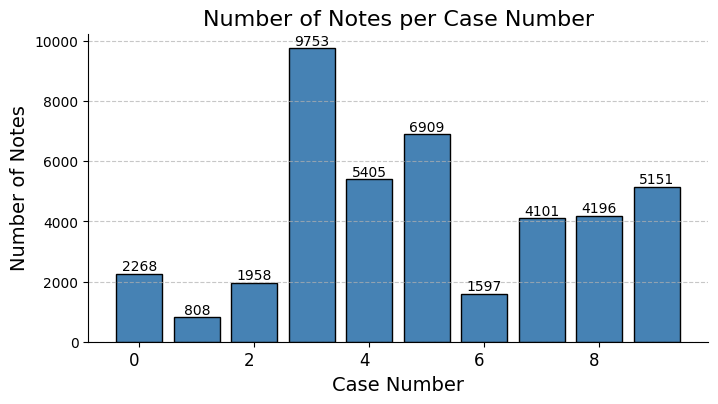

In [10]:
case_nums = case_cnt["case_num"]
counts = case_cnt["count"]

plt.figure(figsize=(8,4 ))
bars = plt.bar(
    case_nums, counts, color="#4682B4", edgecolor="black"
)

plt.xlabel("Case Number", fontsize=14)
plt.ylabel("Number of Notes", fontsize=14)
plt.title("Number of Notes per Case Number", fontsize=16)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(ha="right", fontsize=12)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height}",
        ha="center",
        va="bottom",
        fontsize=10,
    )

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.show()

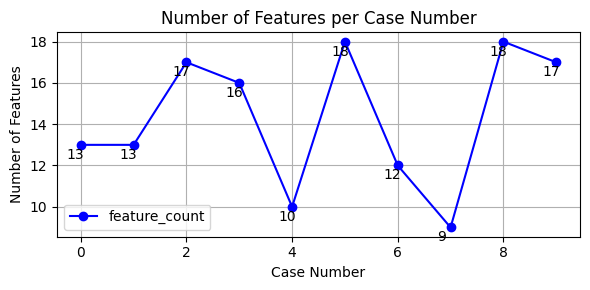

In [11]:
# Assuming 'features_df' is your DataFrame containing the data
identified_features_per_case_cnt = pd.DataFrame(
    features_df.groupby(["case_num"])["case_num"].count()
)

# Rename the column to something meaningful
identified_features_per_case_cnt.columns = ["feature_count"]

# Plotting
identified_features_per_case_cnt.plot(
    kind="line", figsize=(6, 3), marker="o", color="b"
)
plt.xlabel("Case Number")
plt.ylabel("Number of Features")
plt.title("Number of Features per Case Number")
plt.grid(True)
# Annotating data points
for idx, val in identified_features_per_case_cnt.iterrows():
    plt.annotate(
        str(val["feature_count"]),
        xy=(idx, val["feature_count"]),
        xytext=(-10, -10),
        textcoords="offset points",
    )
plt.tight_layout()

plt.show()

In [ ]:
from transformers import AutoTokenizer, AutoModel, AutoConfig

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

In [ ]:
def transform_by_patient(df):
    df_new = pd.DataFrame(df.pn_num.unique(), columns=["pn_num"])
    df["location_span"] = df.location.apply(ast.literal_eval)

    location_lst = []
    notes = []
    case = []
    for num in df.pn_num.unique():
        idx = df.pn_num == num
        locations = df.loc[idx, ["feature_num", "location_span"]]
        notes.append(df.pn_history[idx].tolist()[0])
        case.append(df.case_num[idx].tolist()[0])
        location_flat = {}
        for _, feat, loc in locations.itertuples():
            location_flat[feat] = loc
        location_lst.append(location_flat)

    df_new["case_num"] = case
    df_new["location_lst"] = location_lst
    df_new["pn_history"] = notes
    note_lens = []

    for note in notes:
        token_lst = tokenizer.tokenize(note)
        note_len = len(token_lst)
        note_lens.append(note_len)

    df_new["note_lens"] = note_lens
    feat_lens = []
    for location in df_new.location_lst:
        instance_len = [feat for feat, value in location.items() if value]
        feat_lens.append(len(instance_len))

    df_new["feat_lens"] = feat_lens

    return df_new

In [ ]:
df_patient = transform_by_patient(df)

In [ ]:
note_lens = np.array(df_patient.note_lens)
n, bins, patches = plt.hist(note_lens, bins=40, rwidth=0.8)
plt.xlabel("Length of Patient Notes", fontsize=15)
plt.ylabel("Count", fontsize=15)

In [ ]:
print(f"Max note length: {np.max(note_lens)}")
print(f"Average noken length: {np.mean(note_lens)}")
print(f"Median noken length: {np.median(note_lens)}")

## Case-Specific Summary

In [ ]:
case_num = pd.DataFrame(df_patient.groupby(["case_num"])["case_num"].count())

In [ ]:
case_num["avg_note_lens"] = (
    df_patient.groupby(["case_num"])["note_lens"].mean().tolist()
)
case_num["feature_num"] = features_df.groupby(["case_num"])["feature_num"].count().tolist()
case_num["avg_anno"] = df_patient.groupby(["case_num"])["feat_lens"].mean().tolist()

In [ ]:
case_num.rename(columns={"case_num": "count"}, inplace=True)
case_num


### FEATURES

--------
143 rows<br>
3 columns:  
<ol>
 <li>feature_num : unique ID no. of each complaint/ observation, in increasing order, not continuous<br>143 unique vals</li>  
 <li>case_num : number of patients with that particular complaint/observation<br>10 unique vals</li>  
 <li>feature_text : complaint/observation - distinct<br>131 unique vals</li>
 </ol>

In [ ]:
#extact data from the features.csv file into a pandas dataframe
# features_df = pd.read_csv('../data/nbme-score-clinical-patient-notes/features.csv')
print(features_df.head(5))
print(features_df.columns)
print(len(features_df))

In [ ]:
#unique values in each col of features.csv
for col in features_df.columns:
    print(col, features_df[col].nunique())


### PATIENT NOTES


--------
42146 rows<br>
3 columns:  
<ol>
 <li>pn_num : unique ID no. of each patient, increasing order<br>42146 unique vals
 </li>  
 <li>case_num : **idk what this represents**<br>10 unique vals</li>  
 <li>pn_history : detailed description of complaints and observations. Most patients also have details of PMH, PSHH, FH, Social History, Medications, Sexual history, POS, Family history, Allergies. A patient has either all, or some of these details filled, under either acronyms or varying subheadings.<br>42146 unique vals</li>
 </ol>

In [ ]:
# notes_df = pd.read_csv('../data/nbme-score-clinical-patient-notes/patient_notes.csv')
print(notes_df.head(5))
print(notes_df.columns)
print(len(notes_df))


In [ ]:
# unique values in each col of patient_notes.csv
for col in notes_df.columns:
    print(col, notes_df[col].nunique())

### SAMPLE SUBMISSION
--------

5 rows<br>
2 columns:  
<ol>
 <li>id : submission number<br>5 unique vals
 </li>  
 <li>location : **idk what this represents**<br>3 unique vals, some NaN(blank) values</li>  

 </ol>

In [ ]:
print(samplesub_df.head(5))
print(samplesub_df.columns)
print(len(samplesub_df))
for col in samplesub_df.columns:
    print(col, samplesub_df[col].nunique())

### Train and Test

In [ ]:
train_df.head

In [ ]:
train_df.columns

In [ ]:
print(len(train_df))
print(train_df.shape)

In [ ]:
train_df.head(1)

In [ ]:
test_df.head(5)

In [ ]:
test_df.columns

In [ ]:
# get patient notes for a particular patient with pn_num = 16 m case_num = 1
print(
    notes_df[(notes_df["pn_num"] == 16) & (notes_df["case_num"] == 0)][
        "pn_history"
    ].values[0]
)

In [ ]:
print(features_df[(features_df['feature_num'] == 0) & (features_df['case_num'] == 0)]['feature_text'].values[0])

## Data Analysis